In [1]:
import pandas as pd
import os
import numpy as np

# Plotly graphs
import plotly.figure_factory as ff
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


# Creating data for data "discovery" graphs
In this notebook, we aim to generate plots to explain the dataset that we are using, in a meaningful way for our study. We have 4 external datasets, one of them being our main dataset:
- CMU: Dataset for movies and their actors
- Baby names: Number of birth with a name per year and their gender
- IMDB: Ratings and Number of Votes
- TMDB: Order of characters by importance/relevance in the movie

We will either generate plots with `plotly` and include them on our website, or generate csv files and dynamically gernerate the graphs on the website with D3.js. These datasets are included in `data/processed_data/website/`.

**Note:** There are no titles added to the graphs in the notebook, because they will be added added spearately on the website.

In [2]:
folder_processed_data_path = './processed_data/'
processed_website_data_folder = './processed_data/website/'

We create a **specific style** for plotly so that it matches the style of our website.

In [3]:
# Copy the existing 'plotly_dark' theme
custom_dark_theme = go.layout.Template(pio.templates['plotly_dark'])

# Your custom settings
custom_bg_color = 'rgb(15, 9, 28)'  # Your custom background color
custom_font = 'Poppins'  # Your custom font

# Update the theme layout
custom_dark_theme.layout.update(
    plot_bgcolor=custom_bg_color,
    paper_bgcolor=custom_bg_color,
    font=dict(family=custom_font, color='white'),
    colorway=['rgb(255, 185, 54)', '#FF6F59', '#4ECDC4', '#C7F464', '#F7FFF7'],
    margin=dict(t=0, l=0, b=0, r=0),
)

# Add the custom theme to Plotly's templates
pio.templates['my_custom_dark_theme'] = custom_dark_theme

# Set the custom theme as default
pio.templates.default = 'my_custom_dark_theme'

## 1. CMU dataset: Movie metadata and character names
We are interested in the character names mostly for our study, so we will plot the most common names in the dataset, and group them by genres to give a "taster" of the dataset. 

More precisely, we will show the top 5 genres, and the top 10 names associated with it, as well as their gender and the number of appearances in that specific genre. We will use D3.js to generate bubble groups, where the top 10 character names orbit around a stub that represents the name of the genre.

To achieve this, the plan is to export a csv file `top10_name_top5_genre.csv` with the following columns:
- `genre`: genre of the movie
- `char_name`: name of the character
- `nb_movies`: number of movies in which the character appears for this genre
- `percentage`: percentage of movies in which the character appears for this genre (purely for styling purposes)
- `is_genre`: is this entry a stub for the genre? (a shortcut for easier data generation)
- `gender`: gender of the character

In [4]:
# Import the name by movie
name_by_movie_df = pd.read_csv(os.path.join(folder_processed_data_path, 'name_by_movie_ordered_pvalue_10_5_df.csv'))
print("name_by_movie_ordered_pvalue_10_5_df :")
display(name_by_movie_df.sample(2))
print(f"length : {len(name_by_movie_df)}\n")

# Import movie genres
movie_genres_df = pd.read_csv(os.path.join(folder_processed_data_path, 'movie_genres_df.csv'))
print("movie_genres_df :")
display(movie_genres_df.sample(2))
print(f"length : {len(movie_genres_df)}\n")

# Import the movie dataframe
movie_df = pd.read_csv(os.path.join(folder_processed_data_path, 'movie_df.csv'))
print("movie_df :")
display(movie_df.sample(2))
print(f"length : {len(movie_df)}")

name_by_movie_ordered_pvalue_10_5_df :


,wiki_ID,char_words,order,gender,t_stat,p_value,slope_change
107842,15384415,Charlee,NaN,M,-3.979873,0.002159,0.002744
138809,24048632,Paul,0.0,M,-2.169814,0.052794,0.003289


length : 172906

movie_genres_df :


,wiki_ID,genre
110370,11482407,Road movie
86442,7583011,Mystery


length : 213854

movie_df :


,wiki_ID,mov_name,year,month,revenue,numVotes,averageRating,poster_url,IMDB_ID
34362,2399954,The Scarlet and the Black,1983,2.0,NaN,3527,7.5,/AqMF6v6MErxhajhwZXJUYKiCaqH.jpg,tt0086251
29131,35159090,Macadam Tribu,1996,9.0,NaN,15,6.5,NaN,tt0116952


length : 65503


In [5]:
# Keep only the movie_id and name and drop duplicates as we remove the gender column
char_name_per_movie = name_by_movie_df[['wiki_ID', 'char_words']].drop_duplicates()
display(char_name_per_movie.sample(2))
print(f"Length change : {len(name_by_movie_df)} -> {len(char_name_per_movie)}")

,wiki_ID,char_words
68950,5429460,Madge
17005,565879,Kari


Length change : 172906 -> 167984


In [6]:
# Add a column with the genre of the movie
char_name_per_movie_with_genre = char_name_per_movie.merge(movie_genres_df, on='wiki_ID', how='left').copy(deep=True)

# Rearrange and rename the columns
char_name_per_movie_with_genre = char_name_per_movie_with_genre[['genre', 'char_words', 'wiki_ID']].copy(deep=True)
char_name_per_movie_with_genre.rename(columns={'char_words': 'char_name', 'wiki_ID': 'movie_id'}, inplace=True)

display(char_name_per_movie_with_genre.sample(2))
print(f"Length change : {len(char_name_per_movie)} -> {len(char_name_per_movie_with_genre)}") # the increase is due to the fact that some movies have multiple genres

,genre,char_name,movie_id
692034,Romance Film,Frank,28417976
568501,World cinema,Dekker,18995832


Length change : 167984 -> 739925


In [7]:
# For each name and genre, count the number of movies
movie_count_per_name_and_genre = char_name_per_movie_with_genre.groupby(['genre', 'char_name']).count().reset_index()
movie_count_per_name_and_genre.rename(columns={'movie_id': 'nb_movies'}, inplace=True)
display(movie_count_per_name_and_genre.sample(10))
print(f"Length of movie_count_per_name_and_genre : {len(movie_count_per_name_and_genre)}")

,genre,char_name,nb_movies
81464,Crime Fiction,Morrie,2
81062,Crime Fiction,Malika,1
165560,Musical,Sunny,8
100133,Drama,Hubbard,11
228687,Suspense,Di,1
83930,Crime Thriller,Brenner,2
239050,Thriller,Manville,1
114253,Family Drama,Nicky,1
67639,Comedy-drama,Sherri,1
28323,B-movie,El,1


Length of movie_count_per_name_and_genre : 254789


In [8]:
# List of irrelevant names
irrelevant_names = ['The', 'Agent', 'Man', 'Girl', 'General', 'Young', 'Chief', 'Captain', 'Sheriff']

# Filter rows where 'char_name' is not in the list of irrelevant names
movie_count_per_name_and_genre = movie_count_per_name_and_genre[~movie_count_per_name_and_genre['char_name'].isin(irrelevant_names)].copy(deep=True)

In [9]:
# For each genre, keep only the 10 names with the most counts
movie_count_per_name_and_genre.reset_index(inplace=True)
movie_count_per_name_and_genre.sort_values(by=['genre', 'nb_movies'], ascending=False, inplace=True)
top10_per_genre = movie_count_per_name_and_genre.groupby('genre').head(10).reset_index(drop=True)
top10_per_genre.set_index(['genre', 'char_name'], inplace=True)
display(top10_per_genre)

index  nb_movies
genre       char_name                   
Zombie Film Alice      254325          6
            Frank      254486          5
            Ben        254358          4
            Doctor     254447          4
            Herbert    254519          4
...                       ...        ...
Absurdism   George        176          4
            King          271          4
            Roger         414          4
            Thompson      476          4
            Alan            7          3

[3145 rows x 2 columns]

In [10]:
# Keep only the rows with a genre among the 5 genres with the highest number of names
top5_genres = movie_count_per_name_and_genre.groupby('genre').sum().sort_values(by='nb_movies', ascending=False).head(5).index
top10_name_top5_genre = top10_per_genre.loc[top5_genres, :].copy(deep=True)
top10_name_top5_genre.drop(columns=['index'], inplace=True)

# For styling: Rename the genre 'Romance Film' to 'Romance'
top10_name_top5_genre.reset_index(inplace=True)
top10_name_top5_genre.loc[top10_name_top5_genre['genre'] == 'Romance Film', 'genre'] = 'Romance'
top10_name_top5_genre.set_index(['genre', 'char_name'], inplace=True)
display(top10_name_top5_genre.sample(2))

,,nb_movies
genre,char_name,
Comedy,Mary,180
Drama,David,324


Let's compute the percentages for the sizes of the dots. First lets compute the total number of movie per genre:

In [11]:
# Count the number of movie per genre
nb_movies_per_genre = char_name_per_movie_with_genre.reset_index().groupby('genre')['movie_id'].count().to_frame()
nb_movies_per_genre.columns = ['total_nb_movies']

# Replace the genre "Romance Film" by "Romance" in the nb_movies_per_genre dataframe
nb_movies_per_genre.reset_index(inplace=True)
nb_movies_per_genre.loc[nb_movies_per_genre['genre'] == 'Romance Film', 'genre'] = 'Romance'
nb_movies_per_genre.set_index('genre', inplace=True)
display(nb_movies_per_genre)

# Add total number of movies per genre in a new column of char_name_per_movie_with_genre
top10_name_top5_genre_with_percent = top10_name_top5_genre.reset_index().merge(nb_movies_per_genre, on='genre', how='left').copy(deep=True)

# Compute the percentage of movies per genre for each name and add it in a new column of top10_name_top5_genre
top10_name_top5_genre_with_percent['percentage'] = top10_name_top5_genre_with_percent['nb_movies'] / top10_name_top5_genre_with_percent['total_nb_movies']

# Drop the total_nb_movies column
top10_name_top5_genre_with_percent.drop(columns=['total_nb_movies'], inplace=True)
top10_name_top5_genre_with_percent.set_index(['genre', 'char_name'], inplace=True)
display(top10_name_top5_genre_with_percent.head(11))


,total_nb_movies
genre,
Absurdism,712
Acid western,29
Action,30904
Action Comedy,959
Action Thrillers,2704
...,...
Women in prison films,51
Workplace Comedy,641
World cinema,14972


nb_movies  percentage
genre  char_name                       
Drama  John             701    0.007477
       Jack             426    0.004544
       Mary             379    0.004043
       Joe              338    0.003605
       Paul             334    0.003563
       Frank            333    0.003552
       George           325    0.003467
       David            324    0.003456
       Tom              307    0.003275
       James            280    0.002987
Comedy John             261    0.004930

Each genre is a cluster of 10 names. In order to represent the genre on the plot, we add a supplementary node acting as label for the cluster as explained before. We call these the **stubs.**


In [12]:
# Need to add a column to indicate if the node is a genre label node or not
top10_name_top5_genre_with_percent['is_genre'] = False

In [13]:
# Get the unique genre in top10_name_top5_genre_with_percent
top5_genre = top10_name_top5_genre_with_percent.reset_index()['genre'].unique()

# Create empty lists for each column
genre_lst = []
char_names_lst = []
nb_movies_lst = []
percentage_lst = []
is_genre_lst = []

# For each genre, add a row with the genre as char_name and genre as genre
for genre in top5_genre:
    genre_lst.append(genre)
    char_names_lst.append(genre)
    nb_movies_lst.append(nb_movies_per_genre.loc[genre]['total_nb_movies'])
    percentage_lst.append(np.sqrt(np.square(top10_name_top5_genre_with_percent.loc[genre]['percentage']).sum()))
    is_genre_lst.append(True)

# Create the dataframe with new rows
new_rows_data = {'genre': genre_lst, 'char_name': char_names_lst, 'nb_movies': nb_movies_lst, 'percentage': percentage_lst, 'is_genre': is_genre_lst}
new_rows_df = pd.DataFrame(new_rows_data)

top10_name_top5_genre_with_genre_nodes = pd.concat([top10_name_top5_genre_with_percent.reset_index(), new_rows_df], axis=0)
top10_name_top5_genre_with_genre_nodes.set_index(['genre', 'char_name'], inplace=True)

In [14]:
# Add gender column (Mary was the only female name, sad)
top10_name_top5_genre_with_genre_nodes['gender'] = 'm'
top10_name_top5_genre_with_genre_nodes.loc[(slice(None), 'Mary'), 'gender'] = 'f'

In [15]:
# Export top10_name_top5_genre.csv
display(top10_name_top5_genre_with_genre_nodes.sample(10))
top10_name_top5_genre_with_genre_nodes.to_csv(os.path.join(processed_website_data_folder, 'top10_name_top5_genre.csv'), index=True)

nb_movies  percentage  is_genre gender
genre    char_name                                        
Romance  Paul             129    0.003515     False      m
Comedy   Mary             180    0.003400     False      f
         John             261    0.004930     False      m
Thriller Thriller       38968    0.014721      True      m
Romance  Mary             142    0.003869     False      f
Action   Jim               85    0.002750     False      m
Drama    Jack             426    0.004544     False      m
Romance  Joe              127    0.003460     False      m
Thriller James            152    0.003901     False      m
Action   Action         30904    0.014293      True      m

## 2. IMDB dataset: Ratings and Number of Votes
We create a graph that show the distribution of the ratings and the number of votes for each movie. We will use `plotly` to generate the graph, and export it as a html file.

In [16]:
folder_processed_data_path = './processed_data/'

# Import imdb raw data
movie_df = pd.read_csv(folder_processed_data_path + 'movie_df.csv')
display(movie_df.sample(2))

# Add a log_numVotes column because plotly does not support log scale for histogram
movie_df['log_numVotes'] = np.log10(movie_df['numVotes'])

,wiki_ID,mov_name,year,month,revenue,numVotes,averageRating,poster_url,IMDB_ID
2704,10640941,Maaveeran,1986,NaN,NaN,113,5.4,/kkjyxHMTRRmlcEMDIdXZXub2oGo.jpg,tt0318433
12936,27573663,The Crowd Roars,1938,8.0,NaN,451,6.7,NaN,tt0030031


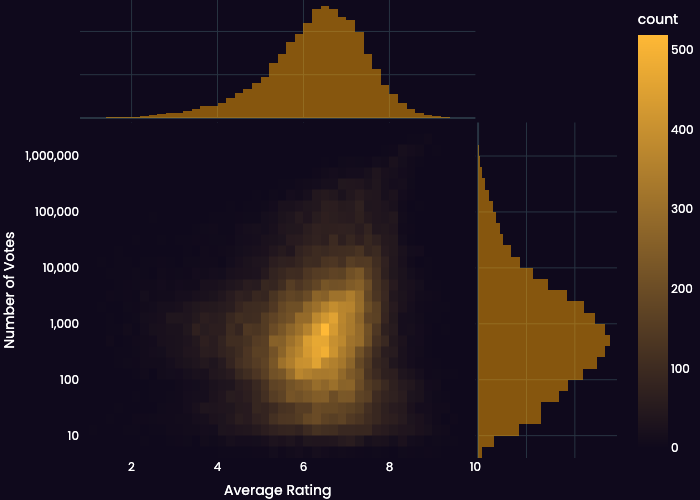

In [17]:
fig = px.density_heatmap(movie_df, 
                         x="averageRating", 
                         y="log_numVotes", 
                         marginal_x="histogram", 
                         marginal_y="histogram", 
                         labels={'averageRating':'Average Rating', 'log_numVotes':'Log Number of Votes', 'log_numVotes':'Number of Votes'},
                         color_continuous_scale=['rgb(15, 9, 28)', 'rgb(255, 185, 54)'])

# Update the color of the marginal histograms
fig.update_traces(marker=dict(color='orange'), selector=dict(type='histogram'))
y_ticks = [10**i for i in range(int(np.floor(movie_df['log_numVotes'].min())), int(np.ceil(movie_df['log_numVotes'].max())) + 1)]
fig.update_layout(yaxis=dict(tickvals=np.log10(y_ticks), ticktext=[f"{int(val):,}" for val in y_ticks]))

fig.show(renderer="png")

In [18]:
# Export to html
fig.write_html('imdb_heatmap.html', include_plotlyjs="cdn", config={'displayModeBar': False})

## 3. TMDB dataset: Order of importance/relevance of a character in movies
We now create a graphs that showcase content for the TMDB dataset. More precisely, it will be about the order of characters in movies. My aim here is to create 2 graphs in total:
- **Graph A:** A simple graph that shows the average order (importance of role) of the top 10 characters names in movies, ordered by the smallest average order (which means the most important characters). This is to see if some character names get more important roles than others.
- **Graph B:** An interactive graph that shows the name of the top 10 characters names in movies (number of occurences), with a slider that allows to select a specific order. This is to see if some names are usually the leader in the movie, or if they are more often the sidekick.

In [19]:
char_order_df = pd.read_csv('processed_data/name_by_movie_ordered_df.csv')
display(char_order_df)

,wiki_ID,char_words,order,gender
0,3217,Gold,6.0,NaN
1,3217,Linda,7.0,F
2,3217,Henry,4.0,M
3,3217,Duke,4.0,M
4,3217,Warrior,9.0,M
...,...,...,...,...
172901,37478048,Ajay,9.0,M
172902,37501922,Murphy,3.0,F
172903,37501922,Hunter,1.0,M
172904,37501922,John,1.0,M


### 3.1. Graph A
Average order of top 10 characters names in movies

In [20]:
# Drop NaNs in order column
char_order_df = char_order_df.dropna(subset=['order'])

# Sort by order
char_order_df.sort_values('order', inplace=True)

# Clean data from random names that don't make sense
char_order_df['char_words'] = char_order_df['char_words'].apply(lambda a: a if a not in ['The', 'Man', 'Woman', 'Girl', 'Boy'] else np.nan)

# Now set index
char_order_df.set_index(['wiki_ID','char_words'], inplace=True)
display(char_order_df)

order gender
wiki_ID  char_words              
8166078  General       0.0      M
23924255 Carlson       0.0      F
         Elizabeth     0.0      F
905483   Mark          0.0      M
13001345 Damini        0.0      F
...                    ...    ...
31306385 Rock        169.0      M
         Fan         169.0      M
300972   Gill        300.0      M
         Captain     302.0      M
         Green       302.0      M

[138380 rows x 2 columns]

In [21]:
# Group and count
groupped_names_df = char_order_df.groupby(['char_words', 'gender'])['order'].agg(['count', 'mean'])
display(groupped_names_df.sort_values(by=('count'), ascending=False))

,,count,mean
char_words,gender,,
John,M,965,4.065285
Jack,M,643,4.359253
Frank,M,525,4.579048
Mary,F,513,5.019493
Joe,M,476,4.827731
...,...,...,...
Karly,F,1,0.000000
Karma,F,1,11.000000
Karmin,F,1,20.000000


The issue is that now if we do the averages, that means if a name appeared in one movie and was the first character, then for any other famous names that appeared in many movies, it would be harder to get a better average. So we decided to take only the top 100 most used names in movies and work on that.

In [22]:
# Sort by count and take top 100
top_100_char_names_df = groupped_names_df.sort_values(by=('count'), ascending=False).head(100).copy(deep=True)

# Take top 10 for both genders and mix
top_100_char_names_df.reset_index(inplace=True)
top_10_mix = top_100_char_names_df.sort_values(by='mean', ascending=True).head(10).set_index('char_words')
top_10_male = top_100_char_names_df[top_100_char_names_df['gender'] == 'M'].sort_values(by='mean', ascending=True).head(10).set_index('char_words')
top_10_female = top_100_char_names_df[top_100_char_names_df['gender'] == 'F'].sort_values(by='mean', ascending=True).head(10).set_index('char_words')

# Drop count column from all
top_10_mix.drop('count', axis=1, inplace=True)
top_10_male.drop('count', axis=1, inplace=True)
top_10_female.drop('count', axis=1, inplace=True)

# Set values for ranking
top_10_mix['ranking'] = range(1,11)
top_10_male['ranking'] = range(1,11)
top_10_female['ranking'] = range(1,11)

display(top_10_mix)

,gender,mean,ranking
char_words,,,
Kate,F,3.245283,1
Elizabeth,F,3.367150,2
Adam,M,3.837500,3
Anna,F,3.911197,4
Claire,F,3.955056,5
Anne,F,3.962500,6
Ben,M,4.019417,7
William,M,4.023529,8
Julie,F,4.053140,9


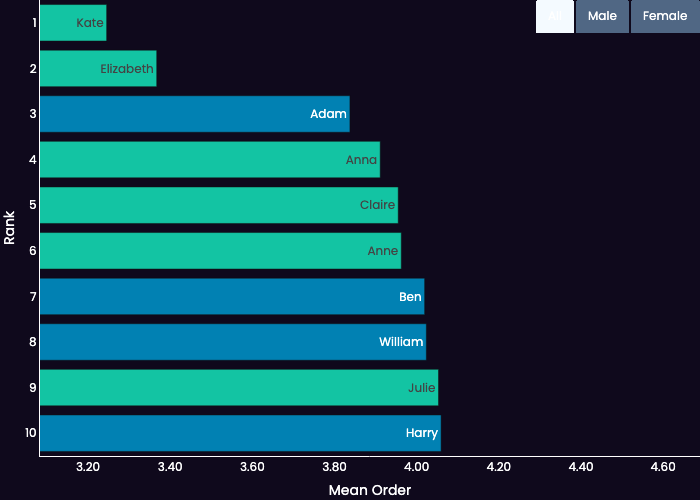

In [23]:
gender_colors = {'m': '#0181b3', 'f': '#13C4A3'}

# Adjusting traces for horizontal orientation
trace_male = go.Bar(y=top_10_male['ranking'], x=top_10_male['mean'], name='Male', orientation='h', marker_color=gender_colors['m'], text=top_10_male.index)
trace_female = go.Bar(y=top_10_female['ranking'], x=top_10_female['mean'], name='Female', orientation='h', marker_color=gender_colors['f'], text=top_10_female.index)
trace_combined = go.Bar(y=top_10_mix['ranking'], x=top_10_mix['mean'], name='Combined', orientation='h', marker_color=[gender_colors['f'] if gender == 'F' else gender_colors['m'] for gender in top_10_mix['gender']], text=top_10_mix.index)

# Creating the figure with all traces
fig = go.Figure(data=[trace_combined, trace_male, trace_female])

# Set the initial visibility to show combined data only
fig.data[0].visible = True
fig.data[1].visible = False
fig.data[2].visible = False

# Finding the min and max mean values for x-axis range
min_mean = min(top_10_male['mean'].min(), top_10_female['mean'].min(), top_10_mix['mean'].min())
max_mean = max(top_10_male['mean'].max(), top_10_female['mean'].max(), top_10_mix['mean'].max())

# Updating layout with interactive buttons
fig.update_layout(
    updatemenus=[
        dict(
            type="buttons",
            direction="right",
            active=0,  # 'All' is active initially
            x=1,
            y=1,
            buttons=list([
                dict(label="All",
                     method="update",
                     args=[{"visible": [True, False, False]}]),
                dict(label="Male",
                     method="update",
                     args=[{"visible": [False, True, False]}]),
                dict(label="Female",
                     method="update",
                     args=[{"visible": [False, False, True]}]),
            ]),
        )
    ],
    xaxis=dict(title='Mean Order', range=[min_mean * 0.95, max_mean * 1.05], tickformat='.2f', showgrid=False, showline=True, linewidth=1, linecolor='white'),
    yaxis=dict(title='Rank', type='category', autorange='reversed', showgrid=False, showline=True, linewidth=1, linecolor='white')
)

# Show the figure
fig.show(config={'displayModeBar': False}, renderer="png")

In [24]:
# Export to html
fig.write_html('top_characters_ranking.html', include_plotlyjs="cdn", config={'displayModeBar': False})

### 3.2. Graph B
Top 10 characters names in movies (number of occurences) with a slider that allows to select a specific order

In [25]:
# Group by order and count names
names_per_order = char_order_df.reset_index().groupby(['order','char_words','gender']).size().reset_index(name='count')

# Keep only top 10 orders, sort by order (ascending) and then name count (descending)
names_per_order = names_per_order[names_per_order['order'] <= 9].sort_values(by=['order', 'count'], ascending=[True, False])

# Artificially add +1 to the order to start from 1
names_per_order['order'] = names_per_order['order'] + 1

# Take top 10 names per order
names_per_order = names_per_order.groupby(['order']).head(10)
names_per_order['order'] = names_per_order['order'].astype(int)
display(names_per_order.set_index(['order','char_words']))

gender  count
order char_words              
1     John            M    300
      Jack            M    180
      James           M    124
      Frank           M    117
      Tom             M    115
...                 ...    ...
10    Sam             M     19
      Jack            M     17
      Captain         M     16
      Joe             M     16
      Billy           M     15

[100 rows x 2 columns]

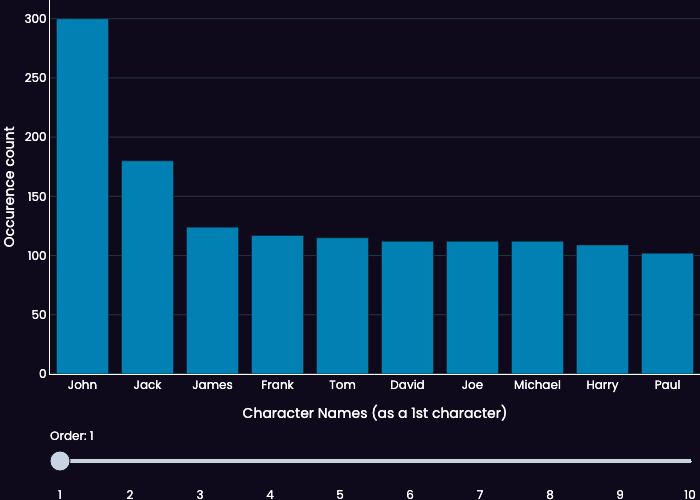

In [26]:
def ordinal_suffix(value):
    if 10 <= value % 100 <= 20:
        suffix = 'th'
    else:
        suffix = {1: 'st', 2: 'nd', 3: 'rd'}.get(value % 10, 'th')
    return str(value) + suffix

# Create a figure
fig = go.Figure()

# Find the unique orders
unique_orders = sorted(names_per_order['order'].unique())

# Add a bar trace for each order
for order in unique_orders:
    filtered_df = names_per_order[names_per_order['order'] == order]
    # Sort by count (descending) for ranking
    filtered_df = filtered_df.sort_values(by='count', ascending=False)
    fig.add_trace(
        go.Bar(
            x=filtered_df['char_words'], 
            y=filtered_df['count'],
            name=f"Order {order}",
            marker_color=filtered_df['gender'].map({'M': gender_colors['m'], 'F': gender_colors['f']}),
            visible=(order == unique_orders[0])  # Only the first trace is visible
        )
    )

# Create and add slider
steps = []
for i, order in enumerate(unique_orders):
    step = dict(
        method="update",
        args=[{"visible": [order == o for o in unique_orders]},
              {"xaxis.title.text": f"Character Names (for a {ordinal_suffix(order)} character)"}],
        label=f"{order}"
    )
    steps.append(step)

sliders = [dict(
    active=0,
    currentvalue={"prefix": "Order: "},
    pad={"t": 50},
    steps=steps
)]

# Update the layout
fig.update_layout(
    sliders=sliders,
    xaxis=dict(title=f'Character Names (as a {ordinal_suffix(1)} character)', showgrid=False, showline=True, linewidth=1, linecolor='white'),
    yaxis=dict(title="Occurence count", showgrid=True, showline=True, linewidth=1, linecolor='white')
)

# Show the figure
fig.show(renderer="png")

In [27]:
# Export to html
fig.write_html('top_character_per_order.html', include_plotlyjs="cdn", config={'displayModeBar': False})

## 4. Baby names: year, count and gender
We are looking at the evolution of the popularity of a name over the years. Therefore it is smart to plot this evolutions. We decided we wanted to show this as a racing graphs with histograms. The idea is to have a slider that allows to select a specific year, and then the histogram will show the number of births for each name, and the names will be ordered by the number of births. 

The histogram will be animated, and the names will be ordered by the number of births. To achieve this animation we used [dexplo's Bar Chart Race](https://github.com/dexplo/bar_chart_race/) python library, that we've slightly modified so that it fits our needs. As it is based on Plotly, we will export the graph as a html file.

In [28]:
import plotly as pl
import plotly.io as pio
import plotly.graph_objects as go
import plotly.express as px
import bar_chart_race as bcr

In [29]:
data_dir = 'processed_data/'
baby_names = pd.read_csv(data_dir + 'baby_name_df.csv')
baby_genders = pd.read_csv(data_dir + 'baby_genders_df.csv', index_col='name')

In [30]:
N_BARS = 12

def union(*l):
    return list(set().union(*l))

# Reshape the data in the way bar_chart_race wants it
babies_wide = baby_names.pivot(index='year', columns='name', values='number')

babies_wide.columns

Index(['Aaban', 'Aabha', 'Aabid', 'Aabidah', 'Aabir', 'Aabriella', 'Aada',
       'Aadam', 'Aadan', 'Aadarsh',
       ...
       'Zytaveon', 'Zytavion', 'Zytavious', 'Zyus', 'Zyva', 'Zyvion', 'Zyvon',
       'Zyyanna', 'Zyyon', 'Zzyzx'],
      dtype='object', name='name', length=102449)

In [31]:
# For efficency, take only the names that appear at least once in the top N_BARS names.
names_interest = []
girls_interest = []
boys_interest = []

# Gender-filtered datasets
girl_names = baby_genders[baby_genders.gender == 'F']
boy_names = baby_genders[baby_genders.gender == 'M']
girls_wide = babies_wide[babies_wide.columns.intersection(girl_names.index)]
boys_wide = babies_wide[babies_wide.columns.intersection(boy_names.index)]

for year in babies_wide.index:
    names_interest.append(babies_wide.loc[year].sort_values(ascending=False).index[:N_BARS])
    girls_interest.append(girls_wide.loc[year].sort_values(ascending=False).index[:N_BARS])
    boys_interest.append(boys_wide.loc[year].sort_values(ascending=False).index[:N_BARS])

names_interest = union(*names_interest)
girls_interest = union(*girls_interest)
boys_interest = union(*boys_interest)
len(names_interest)

86

In [32]:
# Select only the names of interest
to_plot = babies_wide[names_interest]
girls_to_plot = girls_wide[girls_interest]
boys_to_plot = boys_wide[boys_interest]

In [33]:
# Color the bars according to the gender
bar_colors = to_plot.columns.map(baby_genders.gender).map({'M': gender_colors['m'], 'F': gender_colors['f'], np.NaN: '#000'})

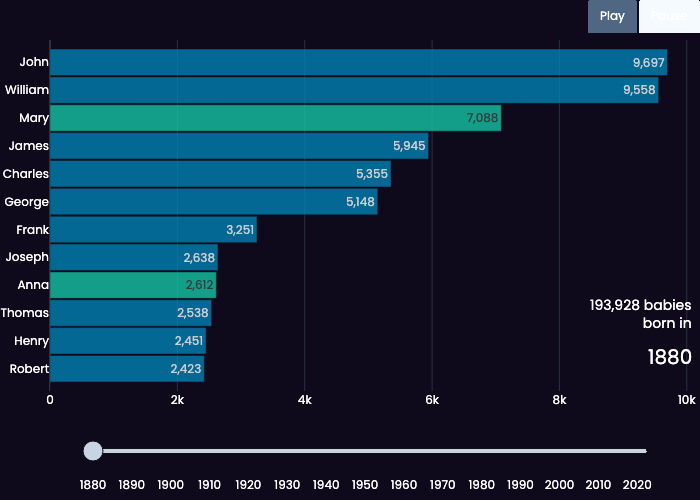

In [34]:
steps_per_period = 5

# Index counter in babies_wide because to_plot doesn't hold info about the total number of babies per year
counter = -1

# Displayed information in period_summary
def period_summary(values, ranks):
    global counter
    counter += 1
    return {
        'x': .99, 'y': .16, 'font': {'size': 14},
        'xref': 'paper', 'yref': 'paper',
        'align': 'right', 'showarrow': False,
        'text': f'{babies_wide.iloc[counter//steps_per_period].sum():,.0f} babies<br>born in'
    }


fig = bcr.bar_chart_race_plotly(
    to_plot,
    n_bars=N_BARS,
    period_label={'x': .99, 'y': .05},
    period_template='{x:.0f}',
    period_summary_func=period_summary,
    filter_column_colors=False,  # Important to get the correct color
    steps_per_period=steps_per_period,
    period_length=400,
    colors=bar_colors,
    end_period_pause=400,
    bar_textposition='inside'
)

fig.show(renderer="png")

In [35]:
# Export to HTML
fig.write_html('baby_race_both.html', include_plotlyjs="cdn", config={'displayModeBar': False})

# Producing plots for understanding the "influence metric" used
We compute the influence metric for each character in a [particular way.](../influence_metric.ipynb) We now aim to explain this on our website and generate static example graphs to illustrate it.

In [36]:
import pandas as pd
import numpy as np
import plotly as pl
import plotly.graph_objects as go

In [37]:
# Copy the existing 'plotly_dark' theme
custom_dark_theme = go.layout.Template(pl.io.templates['plotly_dark'])

# Your custom settings
custom_bg_color = 'rgb(15, 9, 28)'  # Your custom background color
custom_font = 'Poppins'  # Your custom font
custom_colorway = ['rgb(255, 185, 54)', '#FF6F59', '#4ECDC4', '#C7F464', '#F7FFF7']

# Update the theme layout
custom_dark_theme.layout.update(
    plot_bgcolor=custom_bg_color,
    paper_bgcolor=custom_bg_color,
    font=dict(family=custom_font, color='white'),
    colorway=custom_colorway,
    margin=dict(t=0, l=0, b=0, r=0),
)

# Add the custom theme to Plotly's templates
pl.io.templates['my_custom_dark_theme'] = custom_dark_theme

# Set the custom theme as default
pl.io.templates.default = 'my_custom_dark_theme'

In [38]:
data_dir = 'processed_data/'

We start by loading the data:

In [39]:
baby_names = pd.read_csv(data_dir + 'baby_name_df.csv')
movies = pd.read_csv(data_dir + 'movie_df.csv', index_col='wiki_ID')

From preliminary studies, we know that the slope change between before and after the release of Pulp Fiction for the name "Mia" is very clear! We use this as an example.

In [40]:
# Keep only year and percentage values for Mia
Mia_data_short = baby_names[baby_names.name == 'Mia'].pivot(index='year', columns='name', values='percentage')

# Fill in the years where Mia wasn't among the top 1000 by 0
Mia_data = pd.Series(0.0, index=baby_names.year.unique())
Mia_data[Mia_data_short.index] = Mia_data_short.Mia
Mia_data.sort_index(inplace=True)

In [41]:
Mia_data.name = 'percentage'
Mia_data.index.name = 'year'

We also load data about Pulp Fiction, we are interested in the year of release:

In [42]:
Pulp_fiction_data = movies.loc[54173]
x = Pulp_fiction_data.year
y = Mia_data.loc[x]
name = Pulp_fiction_data['mov_name']

Plotting the first figure, with just the time series for proportion of babies named Mia and the year Pulp Fiction was released.

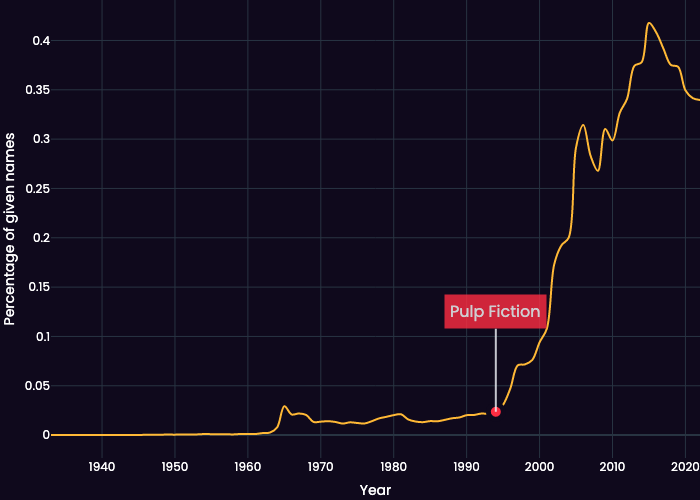

In [43]:
# Create figure
fig = go.Figure()
fig.update_layout(showlegend=False, xaxis_title='Year', yaxis_title='Percentage of given names')

# Add the line plot for Mia as a given name, and adjust axes to keep only the relevant parts.
fig.add_trace(go.Scatter(x=Mia_data.index, y=Mia_data, line_shape='spline', name='Mia'))
fig.update_xaxes(range=[Mia_data_short.index.min(), Mia_data_short.index.max()])

# Add a marker for Pulp Fiction, and add a text box above to make the marker clearer.
fig.add_trace(go.Scatter(  # marker
    x=[x], y=[y], text=[name], name='',
    mode='markers', marker={
        'color': '#ff2d42', 'size': 15, 'line': {'width': 5, 'color': custom_bg_color}
    }  # Color is the same as the markers in the very first plot
))
fig.add_annotation(  # text box
    x=x, y=y, text=name,
    xref='x', yref='y', ax=0, ay=-100,
    font={'size': 16}, align='center',
    showarrow=True, arrowwidth=2,
    borderpad=5, bgcolor='#ff2d42', opacity=0.8
)

# Save the file before calamity happens.
fig.write_html('popularity_curve.html', include_plotlyjs="../../js/plotly-2.12.1.min.js", config={'displayModeBar': False})
fig.show(renderer="png")

We zoom in around 1994 (release of Pulp Fiction) and detail how we calculated the metric.

In [44]:
# Specifying the ranges of interest for years before and after the release date.
range_before = np.arange(x-10, x, 1)
range_after = np.arange(x, x+5, 1)

# Get the least squares regression coefficients and turn it into a function.
fit_before = np.poly1d(np.polyfit(range_before, Mia_data[range_before], 1))
fit_after = np.poly1d(np.polyfit(range_after, Mia_data[range_after], 1))

How it's calculated: we take the slope of the regression between the 10 years before the release, same thing with the year of release + 4 following years, and the difference between the two is the "influence" metric.

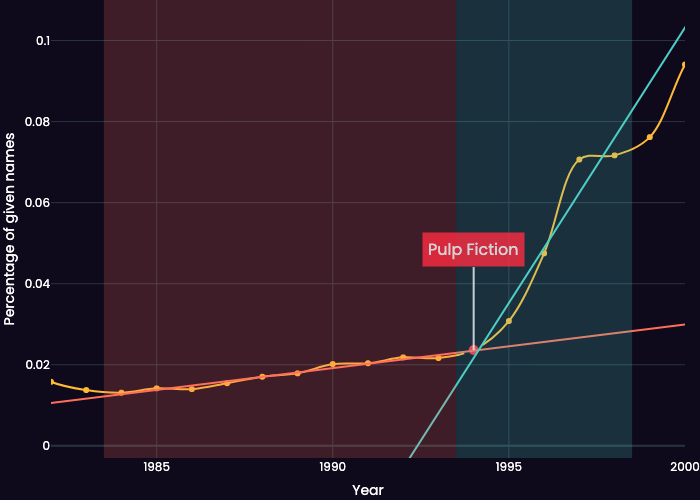

In [45]:
# Change appearance of Mia's curve to make the actual datapoints stand out more
fig.update_traces(selector=0, mode='lines+markers')

# Zoom to dates of interest
fig.update_xaxes(range=[x-12, x+6])
fig.update_yaxes(range=[-0.003, 0.11])

# Highlight dates of interest
fig.add_vrect(x0=x-10.5, x1=x-0.5, line_width=0, fillcolor=custom_colorway[1], opacity=0.2)
fig.add_vrect(x0=x-0.5, x1=x+4.5, line_width=0, fillcolor=custom_colorway[2], opacity=0.2)

# Show the computed regression lines
fig.add_trace(go.Scatter(x=Mia_data.index, y=fit_before(Mia_data.index), mode='lines', line={'color': custom_colorway[1]}, text=f'β1 = {fit_before[1]}', name='before'))
fig.add_trace(go.Scatter(x=Mia_data.index, y=fit_after(Mia_data.index), mode='lines', line={'color': custom_colorway[2]}, text=f'β1 = {fit_after[1]}', name='after'))

# Write to file in case everything is lost.
fig.write_html('influence_regression.html', include_plotlyjs="../../js/plotly-2.12.1.min.js", config={'displayModeBar': False})
fig.show(renderer="png")